In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
import time
sns.set_style("whitegrid")
sns.set_context("poster")

In [5]:
cd ../
location = %pwd

In [8]:
data = pd.read_csv(location+'\\all_ff.csv')

In [9]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('pts_3', axis=1, inplace=True)
data.drop('numbered_game', axis=1, inplace=True)
data.drop('season_mean', axis=1, inplace=True)
data.drop('prev_id', axis=1, inplace=True)
data.drop('prev_mean', axis=1, inplace=True)
data.drop('Opp', axis=1, inplace=True)
data.drop('pred', axis=1, inplace=True)
data.drop('total', axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)

In [4]:
def years(data):
    return list(set(data.year))

def positions(data):
    return list(set(data.pos))

def weeks(data):
    return list(set(data.week))

def teams(data):
    return list(set(data.Team))

def players(data):
    return list(set(data.Name))

In [5]:
def partition(data, year, pos):
    return data[(data["year"] == year) & (data["pos"] == pos)]

In [6]:
def makepairs(data, top_ = 15):
    years_ = years(data)
    positions_ = positions(data)
    weeks_ = weeks(data)
    interactions = pd.DataFrame()
    for year in years_:
        qb_and_wr = pd.DataFrame()
        for pos in positions_:
            top = top_
            if pos == "WR" or pos == "RB":
                top = top*3
            eligible_players = partition(data, year, pos).groupby('Name').Pts.sum().order(ascending=False)[:top]
            temp = data[data['year'] == year]
            temp = temp[temp['Name'].isin(eligible_players.index)]
            qb_and_wr = pd.concat([qb_and_wr, temp])
        for week in weeks_:
            subset = qb_and_wr[qb_and_wr.week == week]
            qbs = subset[subset.pos == positions_[0]]
            wrs = subset[subset.pos == positions_[1]]
            qbs_ = [(row[0], row[1], row[5]) for index, row in qbs.iterrows()]
            wrs_ = [(row[0], row[1], row[5]) for index, row in wrs.iterrows()]
            interactions = pd.concat([pd.DataFrame([[qb[1] + wr[1], int(qb[2] == wr[2]), (qb, wr)] for qb in qbs_ for wr in wrs_]), interactions])
    return interactions

In [7]:
def parseResults(results):
    results.columns = ["Score", "Same Team", "Players"]
    r = results.groupby("Same Team")
    return (r.Score.count(), r.Score.mean(), r.Score.std())

In [8]:
def inject(output, results, i):
    output.loc[i][:2] = results[0]
    output.loc[i][2:4] = results[1]
    output.loc[i][4:6] = results[2]
    return output

In [9]:
def sampleData(data, nsims, pos = ["QB", "WR"]):
    data = data[data['pos'].isin(pos)]
    output = pd.DataFrame(np.nan, index=range(nsims+1), columns=["Count Diff", "Count Same", "Mean Diff", "Mean Same", "Std Diff", "Std Same"])
    temp = parseResults(makepairs(data))
    inject(output, temp, 0)
    teams_ = teams(data)
    players_ = players(data)
    n = len(players_)
    data_sampled = data.copy()
    sample = np.random.choice(teams_, n*nsims)
    for sim in range(nsims):
        for index, player in enumerate(players_):
            data_sampled.ix[data_sampled.Name == player, 'Team'] = sample[(sim*n)+index]
        inject(output, parseResults(makepairs(data_sampled)), sim+1)
    return output

In [10]:
res = makepairs(data)

In [60]:
start_time = time.time()

n = 49

df_qw = sampleData(data, n)
df_qr = sampleData(data, n, pos = ["QB", "RB"])
df_qt = sampleData(data, n, pos = ["QB", "TE"])
df_qd = sampleData(data, n, pos = ["QB", "DST"])
df_qk = sampleData(data, n, pos = ["QB", "K"])
df_wr = sampleData(data, n, pos = ["WR", "RB"])
df_wt = sampleData(data, n, pos = ["WR", "TE"])
df_wd = sampleData(data, n, pos = ["WR", "DST"])
df_wk = sampleData(data, n, pos = ["WR", "K"])
df_rt = sampleData(data, n, pos = ["RB", "TE"])
df_rd = sampleData(data, n, pos = ["RB", "DST"])
df_rk = sampleData(data, n, pos = ["RB", "K"])
df_td = sampleData(data, n, pos = ["TE", "DST"])
df_tk = sampleData(data, n, pos = ["TE", "K"])
df_dk = sampleData(data, n, pos = ["DST", "K"])

end_time = time.time()
print("Elapsed time was %g seconds" % (end_time - start_time))

Elapsed time was 148.95 seconds


In [11]:
def percentile(df, col = 'Std Same'):
    print (df[col].argsort().argsort()[0]+1)/float(len(df))

In [105]:
percentile(df_qw)
#percentile(df_qr)
percentile(df_qt)
#percentile(df_qd)
#percentile(df_qk)
percentile(df_wr)
#percentile(df_wt)
percentile(df_wd)
percentile(df_wk)
percentile(df_rt)
#percentile(df_rd)
#percentile(df_rd)
#percentile(df_td)
#percentile(df_tk)
percentile(df_dk)

1.0
0.86
1.0
0.48
0.84
0.1
0.5
0.04
0.92
0.08
0.84
0.84
0.52
0.86
1.0


In [12]:
#df_qw = sampleData(data, 1000)
df_qw = pd.read_csv('parsed_data.csv')

In [169]:
df_qw['Diff_M']  = (df_qw['Mean Diff'] - df_qw['Mean Same']) *-1
df_qw['Diff_S']  = (df_qw['Std Diff'] - df_qw['Std Same'])*-1

In [180]:
#df_qw.to_csv('parsed_data.csv')

In [71]:
(1001-df_qw['Diff_M'].argsort().argsort())/(1000)

0       0.024
1       0.618
2       0.543
3       0.854
4       0.765
5       0.571
6       0.792
7       0.771
8       0.235
9       0.249
10      0.492
11      0.486
12      0.308
13      0.800
14      0.202
15      0.834
16      0.726
17      0.300
18      0.407
19      0.694
20      0.919
21      0.405
22      0.601
23      0.989
24      0.782
25      0.789
26      0.390
27      0.767
28      0.423
29      0.027
        ...  
971     0.111
972     0.953
973     0.074
974     0.519
975     0.190
976     0.266
977     0.169
978     0.510
979     0.338
980     0.302
981     0.148
982     0.528
983     0.239
984     0.893
985     0.610
986     0.932
987     0.047
988     0.223
989     0.740
990     0.128
991     0.450
992     0.852
993     0.468
994     0.379
995     0.836
996     0.482
997     0.696
998     0.222
999     0.197
1000    0.271
Name: Diff_M, dtype: float64

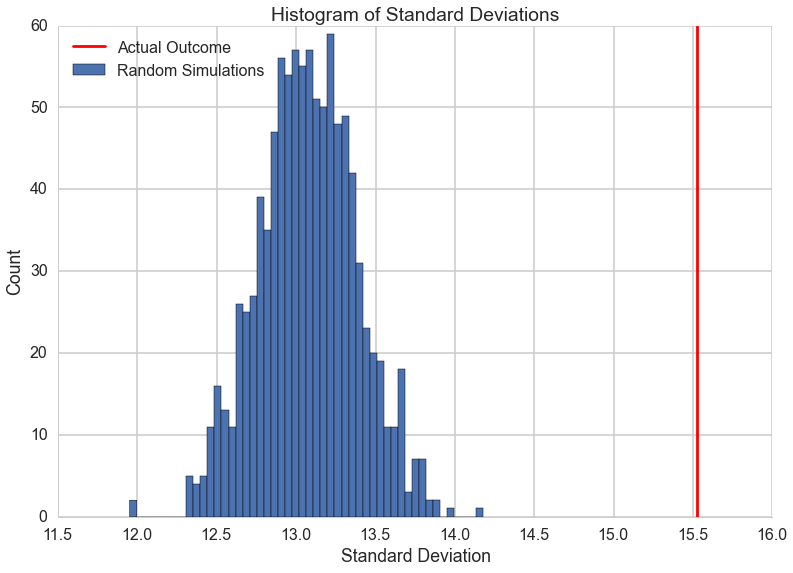

In [57]:
plt.hist(df_qw['Std Same'].ix[1:].values, bins=50, align='left', label = 'Random Simulations')
plt.axvline(df_qw['Std Same'].ix[:0].values, 0, 1, color='r', label='Actual Outcome')
plt.title("Histogram of Standard Deviations")
plt.legend(frameon=False, loc='upper left')
plt.xlabel("Standard Deviation")
plt.ylabel("Count")
sns.despine()
mpl.pylab.savefig('std.png')

In [87]:
print df_qw['Std Same'].ix[1:].values.mean(), df_qw['Std Same'].ix[1:].values.std(), df_qw['Std Same'].ix[:0].values[0]
(df_qw['Std Same'].ix[:0].values[0]-df_qw['Std Same'].ix[1:].values.mean())/df_qw['Std Same'].ix[1:].values.std()

13.0973397309 0.307810568868 15.5262717314


7.8909961066843701

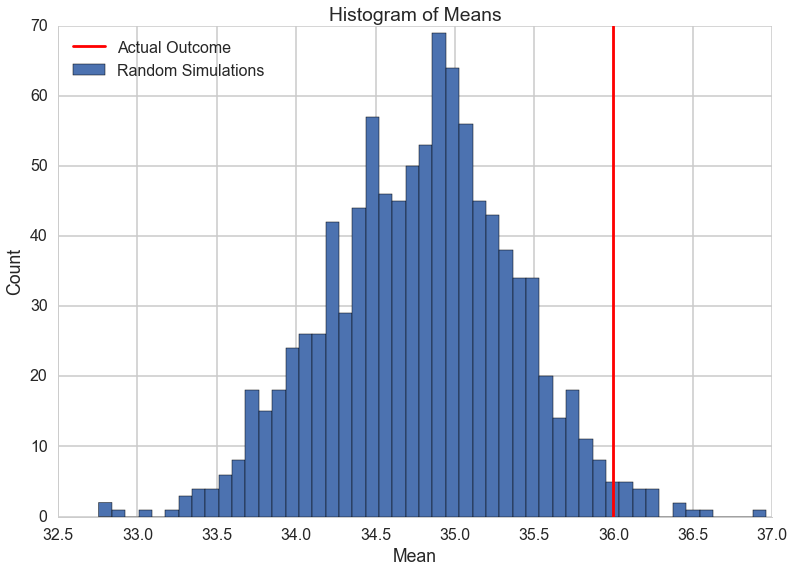

In [56]:
plt.hist(df_qw['Mean Same'].ix[1:].values, bins=50, align='left', label = 'Random Simulations')
plt.axvline(df_qw['Mean Same'].ix[:0].values, 0, 1, color='r', label='Actual Outcome')
plt.title("Histogram of Means")
plt.legend(frameon=False, loc='upper left')
plt.xlabel("Mean")
plt.ylabel("Count")
sns.despine()
mpl.pylab.savefig('ave.png')

In [18]:
colors=sns.color_palette()

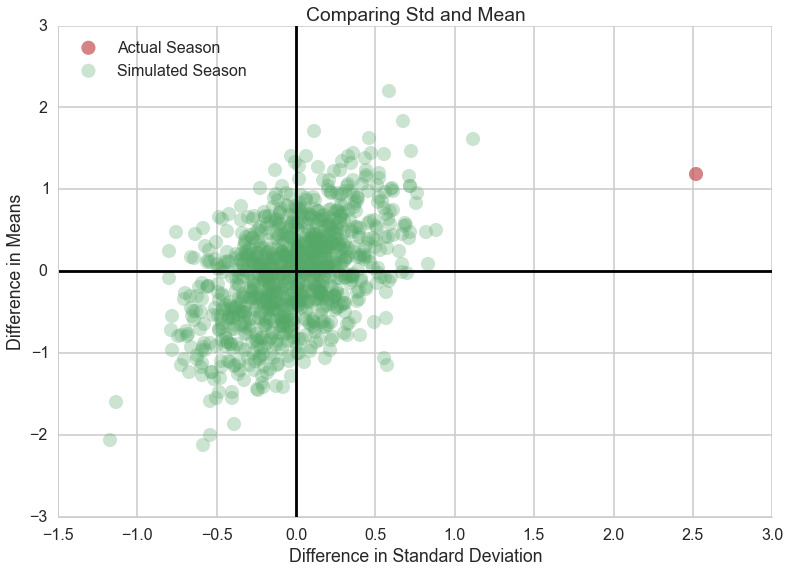

In [90]:
sns.regplot(x = 'Diff_S', y = 'Diff_M', data = df_qw[:1], label = "Actual Season", color = colors[2], fit_reg=False, scatter_kws={"s": 200, 'alpha':0.7})
sns.regplot(x = 'Diff_S', y = 'Diff_M', data = df_qw[1:], label = "Simulated Season", color = colors[1], fit_reg=False, scatter_kws={"s": 200, 'alpha' : 0.3})
plt.axvline(0, 0, 1, color='black')
plt.axhline(0, 0, 1, color='black')
plt.title("Comparing Std and Mean")
plt.legend(frameon=False, loc='upper left')
plt.xlabel("Difference in Standard Deviation")
plt.ylabel("Difference in Means")
sns.despine()
mpl.pylab.savefig('foo2.png')

In [22]:
same = res[res.iloc[:,1]==1]
diff = res[res.iloc[:,1]!=1]
s = same.iloc[:,0].values
d = diff.iloc[:,0].values

In [24]:
z = 1.3
13.01*z+34.81

51.723

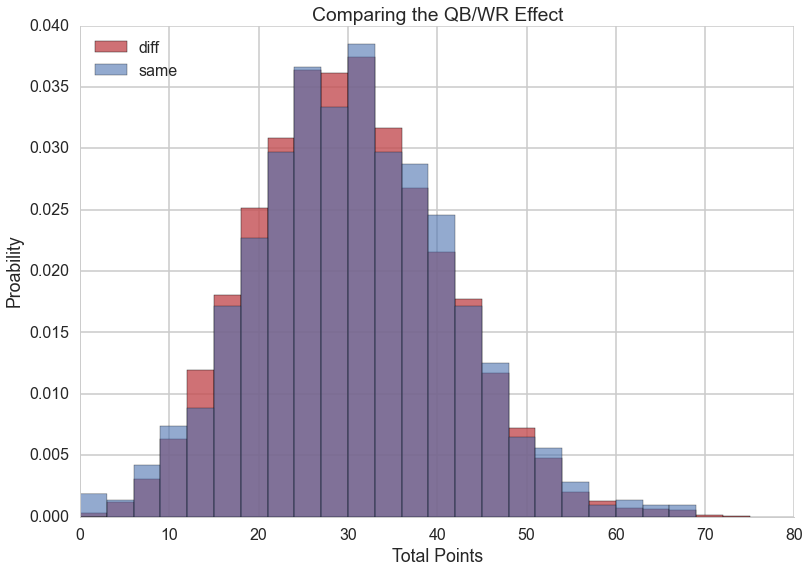

In [52]:
binwidth = 3
plt.hist(d, bins=range(min(d), max(d) + binwidth, binwidth), label='diff', align='mid', normed=True, alpha = .8, color=colors[2])
plt.hist(s, bins=range(min(s)-1, max(s) + binwidth, binwidth), label='same', align='mid', normed=True, alpha = .6, color=colors[0])
plt.title("Comparing the QB/WR Effect")
plt.legend(frameon=False, loc='upper left')
plt.xlabel("Total Points")
plt.ylabel("Proability")
sns.despine()
mpl.pylab.savefig('foo.png')

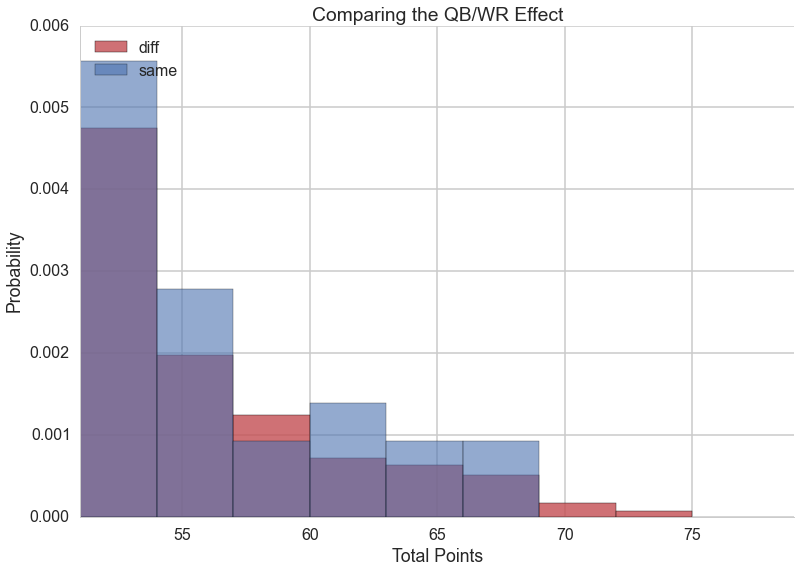

In [80]:
min_ = 51
plt.hist(d, bins=range(min(d), max(d) + binwidth, binwidth), label='diff', align='mid', normed=True, alpha = .8, color=colors[2])
plt.hist(s, bins=range(min(s)-1, max(s) + binwidth, binwidth), label='same', align='mid', normed=True, alpha = .6, color=colors[0])
plt.axis([51,79,0,.006])
plt.title("Comparing the QB/WR Effect")
plt.legend(frameon=False, loc='upper left')
plt.xlabel("Total Points")
plt.ylabel("Probability")
sns.despine()
mpl.pylab.savefig('foo1.png')